This notebook aims at presenting Explanatory Data Analysis & Data Visualization on Covid-19 tweets. The emphasis has been on the text (tweets) and its in-depth analysis for pre-processing. This notebook is prepared on the Covid-19 tweets which are tagged manually from Highly Negative to Highly Positive - i.e. five classes. For the purposes of this study, we will change them to 3 classes (Positive, Negative & Neutal).

Contents:

* [1. Data](#1)
* [2. Class Distribution](#2)
* [3. Number of characters](#3)
* [4. Number of words in a tweet](#4)
* [5. Avg. word length in a tweet](#5)
* [6. Common Stop-words](#6)
* [7. Punctuations](#7)
* [8. Common words](#8)
* [9. Hashtagss](#9)
* [10. Mentions](#10)
* [11. Basic pre-processing](#11)
* [12. Wordclouds](#12)
* [13. N-grams](#13)




In [114]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline # resulting plots are stored in the notebook
import seaborn as sns
plt.style.use('ggplot')

# For mathematical expressions
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
 
# For displaying 500 results in a pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# For documents indexing and vector tokenization
import re
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm # for nested loops

# For Neural Network deep learning
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

# For text processing
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams # generate language models
import string
nltk.download('stopwords')

stop = set(stopwords.words('english'))
plt.style.use('seaborn') # setting seaborn as default

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected = TRUE)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#pip install plotly

UsageError: unrecognized arguments: # resulting plots are stored in the notebook


### [1. Data](#1)



In [115]:
train = pd.read_csv("/Users/wahid/Downloads/Corona_NLP_train.csv",encoding='latin1')
# print(train)
test = pd.read_csv("/Users/wahid/Downloads/Corona_NLP_test.csv.xls",encoding='latin1')
# print(train,test)

df = pd.concat([train,test])
# Changing the tweets into strings
df['OriginalTweet'] = df['OriginalTweet'].astype(str)
df['Sentiment'] = df['Sentiment'].astype(str)
train['OriginalTweet'] = train['OriginalTweet'].astype(str)
test['Sentiment'] = test['Sentiment'].astype(str)
print(df.dtypes)

print('Training Set Shape = {}'.format(train.shape))
print('Test Set Shape = {}'.format(test.shape))
print(train.head())
print("\n")
print("\n")


UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object
Training Set Shape = (41157, 6)
Test Set Shape = (3798, 6)
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  






In [116]:
print("Shape of the duplicates before dropping the duplicates: ", df.shape)

# Dropping duplicates
train.drop_duplicates()
print("Shape of the dataframe after dropping duplicates: ", df.shape)

# Checking for Null values
null = df.isnull().sum().sort_values(ascending = False)
total = df.shape[0] # Total rows
percent_missing = (df.isnull().sum()/total).sort_values(ascending = False)

missing_data= pd.concat([null, percent_missing], axis = 1, keys = ['Total missing', 'Percent Missing'])
print(missing_data)

missing_data.reset_index(inplace = True) # for multiple indexes old index adds as a column
missing_data = missing_data.rename(columns = {'index': 'Column'})
print("\n Null values in each column: \n\n", missing_data)

Shape of the duplicates before dropping the duplicates:  (44955, 6)
Shape of the dataframe after dropping duplicates:  (44955, 6)
               Total missing  Percent Missing
Location                9424         0.209632
Sentiment                  0         0.000000
OriginalTweet              0         0.000000
TweetAt                    0         0.000000
ScreenName                 0         0.000000
UserName                   0         0.000000

 Null values in each column: 

           Column  Total missing  Percent Missing
0       Location           9424         0.209632
1      Sentiment              0         0.000000
2  OriginalTweet              0         0.000000
3        TweetAt              0         0.000000
4     ScreenName              0         0.000000
5       UserName              0         0.000000


In [117]:
# Count
print('Total tweets: {}'.format(df.shape[0]))
print('Total unique users: {}'.format(df['UserName'].nunique()))
print(df.Sentiment.unique())
print(df.Sentiment.value_counts(), df.Sentiment.value_counts()/total )

Total tweets: 44955
Total unique users: 44955
['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64 Positive              0.275142
Negative              0.243755
Neutral               0.185341
Extremely Positive    0.160672
Extremely Negative    0.135091
Name: Sentiment, dtype: float64


In [118]:
df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Converting 5 classes in 3 forms of sentiments
def classes_def(x):
    if x ==  "Extremely Positive":
        return "Positive"
    elif x == "Extremely Negative":
        return "Negative"
    elif x == "Negative":
        return "Negative"
    elif x ==  "Positive":
        return "Positive"
    else:
        return "Neutral"

# Implementing the change in class over the data   
df['Sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['Sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['Sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['Sentiment']

# Setting up the target variable name

df.Sentiment.value_counts(normalize= True)

Positive    0.435814
Negative    0.378846
Neutral     0.185341
Name: Sentiment, dtype: float64

In [119]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,"Me, ready to go at supermarket during the #COV..."
...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,Meanwhile In A Supermarket in Israel -- People...
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,Did you panic buy a lot of non-perishable item...
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,Asst Prof of Economics @cconces was on @NBCPhi...
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative,Gov need to do somethings instead of biar je r...


### [2. Class Distribution](#2)

In [120]:
# Rechanging the index to [i]
class_df = df.groupby('Sentiment').count().reset_index().sort_values(by = 'text', ascending = False)
class_df.columns = ['Sentiment','UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet','Text']
print('There is an uneven distribution of classes for Covid-19 tweets primarly leaning towards more Positive tweets:')
class_df.style.background_gradient(cmap = 'summer')

There is an uneven distribution of classes for Covid-19 tweets primarly leaning towards more Positive tweets:


,Sentiment,UserName,ScreenName,Location,TweetAt,OriginalTweet,Text
2,Positive,19592,19592,15590,19592,19592,19592
0,Negative,17031,17031,13272,17031,17031,17031
1,Neutral,8332,8332,6669,8332,8332,8332


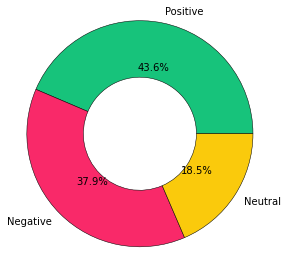

In [121]:
# Using Pie charts
percent_class = class_df.Text
labels = class_df.Sentiment
colors = ['#17C37B','#F92969','#FACA0C']
Pie_chart,_,_ = plt.pie(percent_class, radius = 1.3, labels = labels, colors = colors, autopct ='%.1f%%')

plt.setp(Pie_chart, width = 0.65, edgecolor = 'black')
plt.show()


 The color codes used above to represent different levels of sentiments are to be used for the remaining of the study for Data Visualization.
 

In [123]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.Sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.Sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)             

### [3. Number of characters](#3)

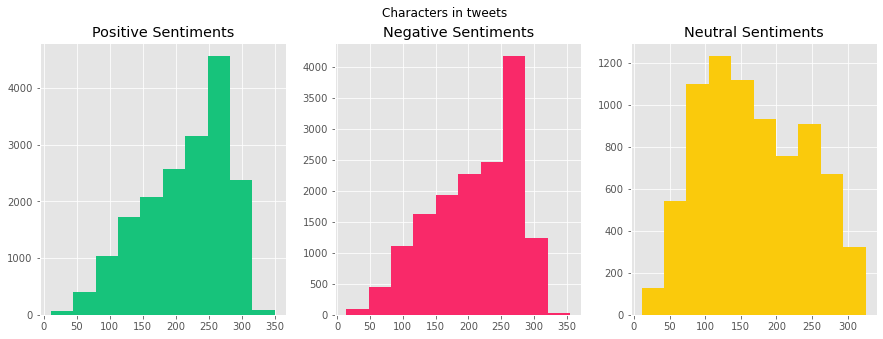

In [124]:
fig, (x1,x2,x3) = plt.subplots(1,3,figsize = (15,5))

# Calculating the length of characters for each tweet for Positive sentiments
tweet_len = train[train['Sentiment'] =='Positive']['text'].str.len()
x1.hist(tweet_len, color = '#17C37B')
x1.set_title('Positive Sentiments')

# Calculating the length of characters for each tweet for Negative sentiments
tweet_len = train[train['Sentiment'] == 'Negative']['text'].str.len()
x2.hist(tweet_len, color ='#F92969')
x2.set_title('Negative Sentiments')


# Calculating the length of characters for each tweet for Neutral sentiments
tweet_len = train[train['Sentiment']== "Neutral"]['text'].str.len()
x3.hist(tweet_len, color = '#FACA0C')
x3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
#plt.style.available('gglplot')
plt.show()
plt.style.use('ggplot')



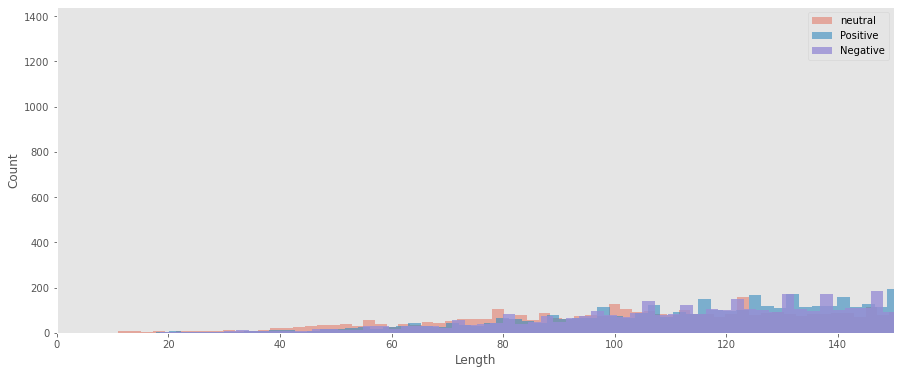

In [125]:
import matplotlib.pyplot as plt 
# Function that returns the length of the string
def length(text):
    ''' a function that returns the length of the text'''
    return len(text)
df['length'] = df['text'].apply(length)
df
plt.figure(figsize = (15,6))
bins = 150

# Plotting the length of each texts 
plt.hist(df[df['Sentiment'] == 'Neutral']['length'], alpha = 0.4, bins = bins, label = 'neutral')
plt.hist(df[df['Sentiment'] == 'Positive']['length'], alpha = 0.6, bins = bins, label = 'Positive')
plt.hist(df[df['Sentiment'] == 'Negative']['length'], alpha = 0.8, bins = bins, label = 'Negative')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend(loc = 'upper right')
plt.xlim(0, 150)
plt.grid()
plt.show()
plt.style.use('ggplot')



### [4.Number of words in a tweet](4)

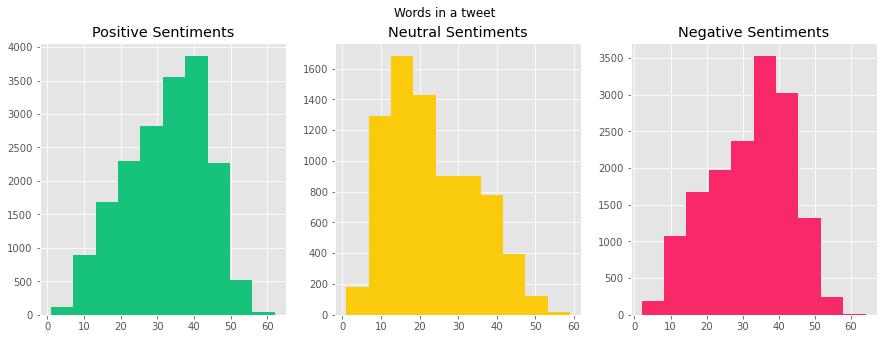

In [126]:
# 4.Number of words in a tweet
fig, (x1,x2,x3) = plt.subplots(1,3 ,figsize = (15,5))
plt.style.use('ggplot')

# Calculating the number of words in a tweet
tweet_len = train[train['Sentiment'] == 'Positive']['text'].str.split().map(lambda x : len(x))
x1.hist(tweet_len, color = '#17C37B')
x1.set_title('Positive Sentiments')

tweet_len = train[train['Sentiment'] == 'Neutral']['text'].str.split().map(lambda x : len(x))
x2.hist(tweet_len, color = '#FACA0C')
x2.set_title('Neutral Sentiments')

tweet_len = train[train['Sentiment'] == 'Negative']['text'].str.split().map(lambda x : len(x))
x3.hist(tweet_len, color = '#F92969')
x3.set_title('Negative Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

### [5. Average word length in a tweet](5)

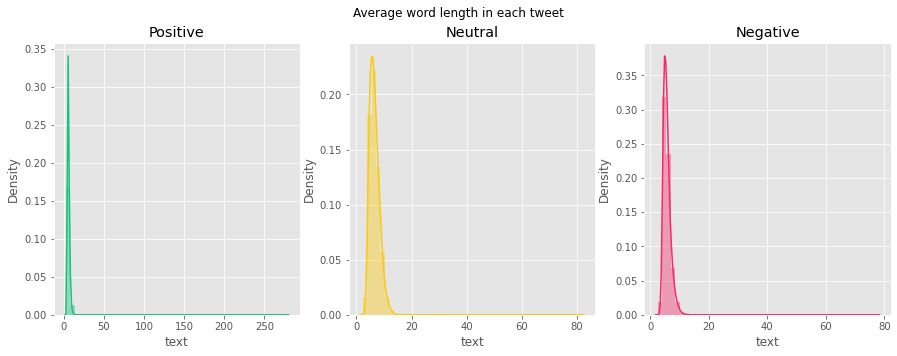

In [127]:
import seaborn as sns
fig, (x1,x2,x3) = plt.subplots(1,3,figsize = (15,5))
plt.style.use('ggplot')

# Calculating the average length of a word within a tweet
len_word = train[train['Sentiment'] == 'Positive']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(len_word.map(lambda x : np.mean(x)), ax = x1, color = '#17C378')
x1.set_title('Positive')

len_word = train[train['Sentiment'] == 'Neutral']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(len_word.map(lambda x : np.mean(x)), ax = x2, color = '#FACA0C')
x2.set_title('Neutral')

len_word = train[train['Sentiment'] == 'Negative']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(len_word.map(lambda x : np.mean(x)), ax= x3, color = '#F92969')
x3.set_title('Negative')

fig.suptitle('Average word length in each tweet')
import warnings
warnings.filterwarnings(action ='ignore')

In [128]:
train[train['Sentiment'] == 'Neutral']['text'].str.split().apply(lambda x : [len(i) for i in x])

0                             [9, 11, 9, 23, 3, 23, 3, 23]
7               [3, 2, 3, 11, 6, 6, 3, 6, 6, 6, 18, 9, 23]
10       [3, 5, 5, 6, 4, 8, 2, 3, 12, 2, 12, 7, 8, 3, 3...
16       [5, 5, 5, 5, 2, 6, 5, 7, 9, 1, 10, 5, 4, 6, 1,...
17       [15, 7, 6, 8, 12, 8, 8, 4, 2, 4, 6, 5, 1, 3, 3...
                               ...                        
41141    [12, 2, 5, 3, 5, 2, 3, 7, 2, 5, 4, 2, 2, 3, 3,...
41143    [23, 11, 13, 12, 16, 6, 26, 12, 2, 6, 2, 14, 4...
41144    [12, 7, 4, 4, 4, 3, 6, 1, 11, 6, 4, 2, 2, 4, 7...
41152               [7, 6, 8, 2, 5, 11, 7, 2, 3, 8, 9, 23]
41155    [2, 2, 5, 4, 3, 5, 2, 4, 9, 2, 8, 2, 4, 2, 3, ...
Name: text, Length: 7713, dtype: object

### [6. Common stopwords in the tweets](6)

In [129]:
# For text processing
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams # generate language models
import string
nltk.download('stopwords')
stop = set(stopwords.words('english'))
print("List of stopwords per the NLTK package: ")
np.array(stop)

List of stopwords per the NLTK package: 


[nltk_data] Downloading package stopwords to /Users/wahid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array({'where', 'hadn', 'does', 'been', "that'll", 'some', 'during', "haven't", 'our', 'yours', 'her', 'their', 'm', "hadn't", 'yourselves', 'what', "don't", 'wouldn', 'we', 'hers', "shan't", 'most', 'if', "isn't", 'its', 'of', 'did', 'themselves', 'to', 'him', 'mustn', "weren't", 'i', 'yourself', 'this', 'once', 'my', 'few', "she's", 'because', "you'd", 'off', 'those', 'further', 'd', 'o', 'will', 'any', 'wasn', 's', 'then', 'ours', 'through', "mightn't", 'but', 'the', 'do', 'his', 'don', 'ourselves', 'am', 'not', 'your', 'against', "you'll", 'myself', 'ain', 'he', 'from', 'herself', 'these', 'them', 'when', 'why', 'before', 'up', 'in', "wasn't", "mustn't", 'won', "won't", 'or', 'theirs', 'above', 'as', 'here', 've', 'shan', 'between', 'who', 'didn', 'whom', "didn't", 'there', 'over', 'too', 'own', 'on', 't', 'nor', 'doesn', 'down', 'himself', 'being', 'with', 'are', 'by', 'very', 'had', 'should', 'just', 'couldn', 'they', 'again', 'while', "should've", 'all', 'an', 'out', "doesn't", 

In [130]:
# A corpus is a collection of multiple text documents
def create_corpus(target):
    corpus=[] # creating a dictionary
    
    for x in train[train['Sentiment']== target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

List of stopwords organized by the order of magnitude:


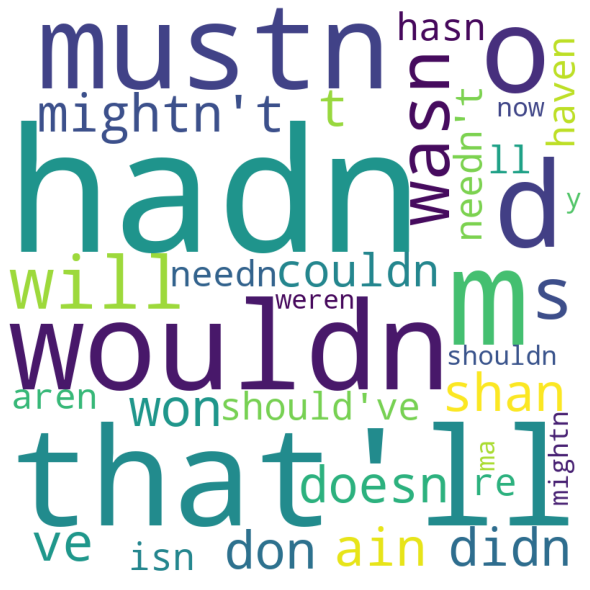

In [131]:
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in stop: #arbitrary list of stopwords from the tweets
      
    # typecaste each val to string 
    val = str(val) 
   # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()  
        
        comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
print('List of stopwords organized by the order of magnitude:')
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

List of Positive Corpus:

 ['advice', 'Talk', 'to', 'your', 'neighbours', 'family', 'to', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'with', 'phone', 'numbers', 'of', 'neighbours', 'schools', 'employer']


<BarContainer object of 12 artists>

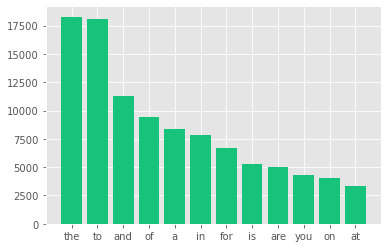

In [133]:
# Positive corpus
corpus = create_corpus('Positive')
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
print('List of Positive Corpus:\n\n', corpus[:20])
                
top = sorted(dic.items(), key = lambda x : x[1], reverse = True)[:12]
x,y = zip(*top)
plt.bar(x,y, color = '#17C37B')


List of Neutral Corpus:

 ['@MeNyrbie', '@Phil_Gahan', '@Chrisitv', 'https://t.co/iFz9FAn2Pa', 'and', 'https://t.co/xX6ghGFzCC', 'and', 'https://t.co/I2NlzdxNo8', 'Was', 'at', 'the', 'supermarket', 'today.', "Didn't", 'buy', 'toilet', 'paper.', '#Rebel', '#toiletpapercrisis', '#covid_19']


<BarContainer object of 12 artists>

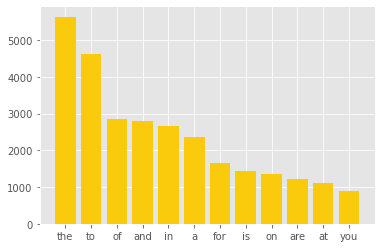

In [134]:
# Neutral Corpus
corpus = create_corpus('Neutral')
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
print('List of Neutral Corpus:\n\n', corpus[:20])
                
top = sorted(dic.items(), key = lambda x : x[1], reverse = True)[:12]
x,y = zip(*top)
plt.bar(x,y, color = '#FACA0C')



List of Negative Corpus:

 ['Me,', 'ready', 'to', 'go', 'at', 'supermarket', 'during', 'the', '#COVID19', 'outbreak.', 'Not', 'because', "I'm", 'paranoid,', 'but', 'because', 'my', 'food', 'stock', 'is']


<BarContainer object of 12 artists>

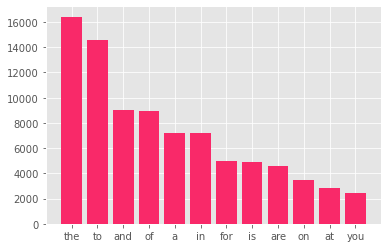

In [135]:
# Negative corpus
corpus = create_corpus('Negative')
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
print('List of Negative Corpus:\n\n', corpus[:20])
top = sorted(dic.items(), key = lambda x : x[1], reverse = True)[:12]
x,y = zip(*top)
plt.bar(x,y, color = '#F92969')

A list of stop words are present in all 3 corpus. Hence a lot of preprocessing is required in the further stages of the study.

### [7. Punctuations](#7)

List of Punctuations in Positive Sentiments:

 dict_items([('/', 93), ('?', 1107), ('-', 1087), ('.', 400), (':', 65), ('|', 207), ('(', 22), (')', 14), ('=', 24), ('#', 53), ('@', 105), ('"', 19), ('$', 18), ('*', 25), (',', 158), ('+', 92), ('~', 11), ('!', 79), ('%', 10), (';', 1), ('&', 1), ('{', 3), ('}', 3), ('_', 1), ("'", 2), ('[', 3), (']', 2)])


<BarContainer object of 27 artists>

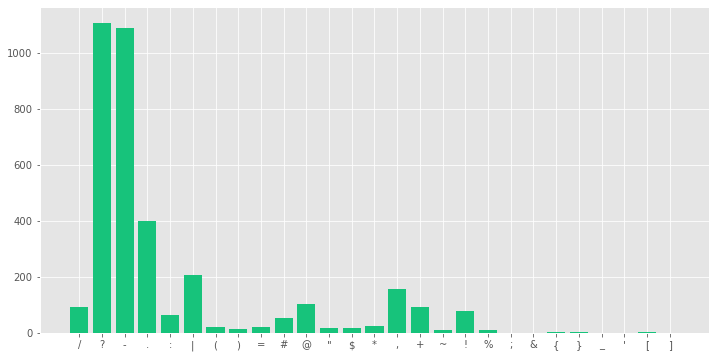

In [137]:
# Positive punctuations
plt.figure(figsize = (12,6))
corpus = create_corpus('Positive')
dic = defaultdict(int)

import string
spec_char = string.punctuation
for punc in corpus:
    if punc in spec_char:
        dic[punc] += 1
        
x,y = zip(*dic.items())
print('List of Punctuations in Positive Sentiments:\n\n', dic.items())
plt.bar(x,y, color = '#17C37B')
        


List of Punctuations in Neutral Sentiments:

 dict_items([('?', 486), ('-', 482), ('|', 128), (')', 6), ('@', 79), ('/', 25), ('.', 192), (':', 44), ('=', 9), (',', 36), ('$', 4), ('+', 17), ('#', 22), ('%', 1), ('!', 12), ('(', 9), ('*', 9), ('~', 5), (';', 2), ('_', 1), ('"', 5), ('&', 1), ('[', 1)])


<BarContainer object of 23 artists>

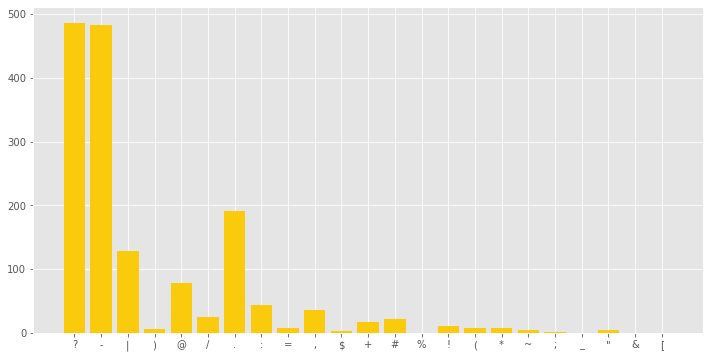

In [138]:
plt.figure(figsize = (12,6))
corpus = create_corpus('Neutral')
dic = defaultdict(int)
spec_char = string.punctuation
for punc in corpus:
    if punc in spec_char:
        dic[punc] += 1

x,y = zip(*dic.items())
print('List of Punctuations in Neutral Sentiments:\n\n', dic.items())
plt.bar(x,y, color = '#FACA0C')

List of Punctuations in Negative Sentiments:

 dict_items([('-', 959), ('?', 750), ('.', 223), (',', 102), (':', 58), ('|', 192), ('/', 61), ('+', 63), ('$', 18), (')', 7), ('(', 15), ('#', 41), ('@', 65), ('"', 25), ('*', 33), ('!', 61), ('=', 44), ('[', 2), (']', 4), ('_', 4), ('~', 13), ("'", 1), (';', 3), ('%', 6), ('!"', 1)])


<BarContainer object of 25 artists>

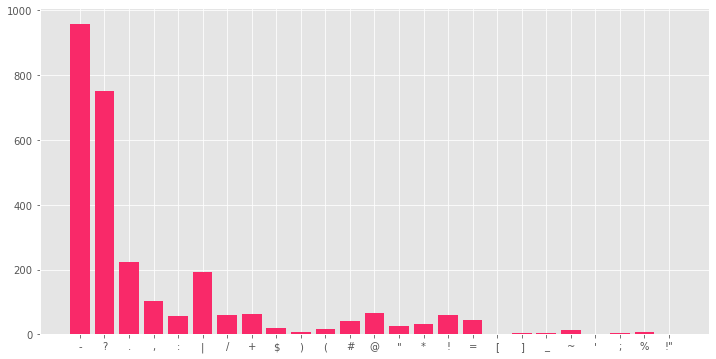

In [139]:
# Negative Punctuations
plt.figure(figsize = (12,6))
corpus = create_corpus('Negative')
dic = defaultdict(int)
spec_char = string.punctuation
for punc in corpus:
    if punc in spec_char:
        dic[punc] += 1

x,y = zip(*dic.items())
print('List of Punctuations in Negative Sentiments:\n\n', dic.items())
plt.bar(x,y, color = '#F92969')

### [8. Common Words](#8)

List of common words:

 [('the', 16420), ('to', 14586), ('and', 9023), ('of', 8958), ('a', 7173), ('in', 7167), ('for', 4953), ('is', 4890), ('are', 4604), ('#coronavirus', 4402), ('on', 3494), ('I', 3284), ('prices', 2924), ('at', 2848), ('food', 2628), ('you', 2435), ('have', 2430), ('with', 2401), ('that', 2392), ('this', 2316)]


<AxesSubplot:>

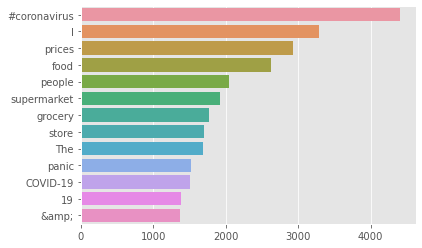

In [140]:
# Making a corpus of common words
counter = Counter(corpus)
popular = counter.most_common()
x =[]
y =[]
for word, count in popular[:50]:
    if word not in stop:
        x.append(word)
        y.append(count)

print('List of common words:\n\n', popular[:20])        
sns.barplot(x = y, y = x)
    

Common words feature punctuations and we need further data cleaning.



### [9. Hashtags](#9)

List of most popular hashtags:

                Hashtag  Count
1             Covid_19   1157
2          Coronavirus    598
3            COVID2019    470
4  coronavirus COVID19    234
5              COVID19    231
6  COVID19 coronavirus    171
7         CoronaCrisis    167
8          CoronaVirus    148
9     SocialDistancing    105


<AxesSubplot:xlabel='Hashtag', ylabel='Count'>

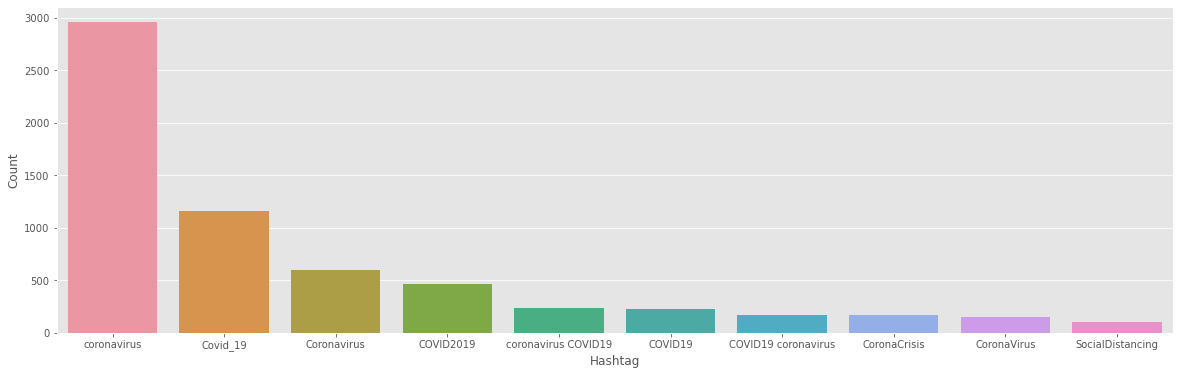

In [141]:
# Making a corpus of hashtags
import re
def find_hash(text):
 # findall() finds *all* the matches and returns them as a list of strings,
#with each string representing one match   
    line = re.findall(r'(?<=#)\w+', text) # calling all the hastags with regex
    return " ".join(line) # makes a list
df['Hash'] = df['text'].apply(lambda x : find_hash(x))
temp = df['Hash'].value_counts()[1:11]
temp = temp.to_frame().reset_index().rename(columns = {'index': 'Hashtag','Hash':'Count'})
plt.figure(figsize = (20,6))
print('List of most popular hashtags:\n\n', temp[1:10])
sns.barplot(x = 'Hashtag', y= 'Count',data = temp)

Donut Chart:




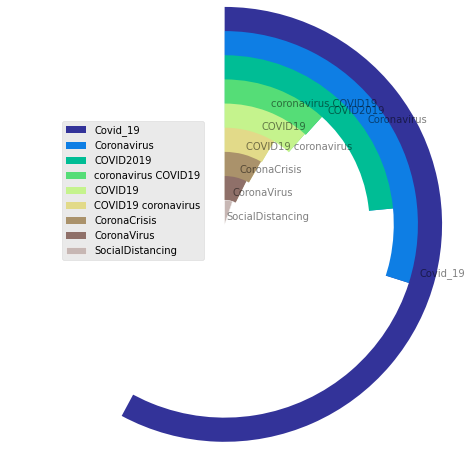

In [142]:
from matplotlib import cm
from math import log10

labels = df['Hash'].value_counts()[2:11].index.tolist() # reindexing to make it into array
data = df['Hash'].value_counts()[2:11]

# Number of data points
n = len(data)

# Calculating the max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

# Radius of the donut chart
r = 2.5
# Width of each ring
w = r/n
# Create colors among the map
colors = [cm.terrain(i / n) for i in range(n)]

# Create figure, axis
fig , x = plt.subplots()
x.axis('Equal')

# Creating rings for the donut chart
# hide labels in segments with textprops: alpha = 0 - transparent , alpha = 1 - visible
for i in range(n):
    innerring, _ = x.pie([m - data[i], data[i]], radius = r - i*w, startangle = 90, 
                     labels = ['', labels[i]], labeldistance = 1 - 1/ (1.5 * (n -i)),
                        textprops = {'alpha' : 0.5}, colors = ['white', colors[i]])
print('Donut Chart:\n\n')
plt.setp(innerring, width = w, edgecolor = 'white')
plt.legend()
plt.show()



### [10. Mentions](#10)

Most popular mentions:


<AxesSubplot:xlabel='Mentions', ylabel='Count'>

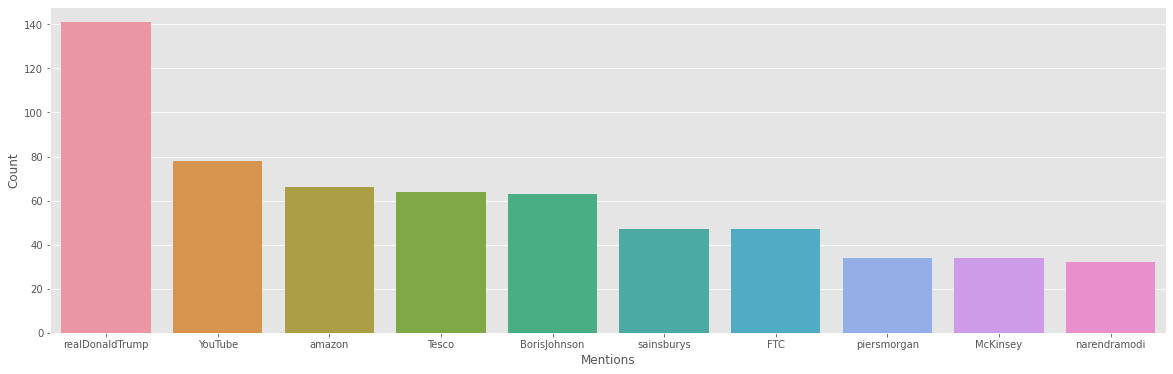

In [143]:
def mentions(text):
    line = re.findall(r'(?<=@)\w+',text) #calling all the tweets with mention
    return " ".join(line)
df['Mentions']  = df['text'].apply(lambda x : mentions(x))
temp = df['Mentions'].value_counts()[1:11]
# o_frame() function is used to convert the given series object to a dataframe.
temp = temp.to_frame().reset_index().rename(columns = {'index' : 'Mentions', 'Mentions' : 'Count'})
temp
plt.figure(figsize = (20,6))
print('Most popular mentions:')
sns.barplot(x="Mentions",y="Count", data = temp)

In [144]:
import plotly.express as px
# Mosaic Plots
x = df['Mentions'].value_counts()[1:11].index.tolist() 
y = df['Mentions'].value_counts()[1:11].tolist()
row = pd.DataFrame({'Scenario': []})
row['Scenario'] = x
row['Percentage'] = y
row
fig = px.treemap(row, path= ["Scenario"], values = "Percentage",title='Tree of Mentions')
fig.show()

### [11. Pre-processing](#11)

In [146]:
# Removing URLs and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'',text)
df['Text_new'] = df['text'].apply(lambda x : remove_urls(x))
df
def remove_html(text):
    html = re.compile(r'<.*?>') # Pattern matching
    return html.sub(r'',text)
# Now applying all the remove functions on to the actual text
df['text'] = df['Text_new'].apply(lambda x : remove_html(x))


In [148]:
# Lower casing
def lower_case(text):
    low_text = text.lower()
    return low_text
df['Text_new'] = df['text'].apply(lambda x : lower_case(x))
#del df['text_new']
# Number removal
def remove_num(text):
    remove = re.sub(r'\d+', '', text) # '\d' Returns a match where the string DOES NOT contain digits
    return(remove)
df['text'] = df['Text_new'].apply(lambda x : remove_num(x))

In [40]:
# Remove Stopwords and Punctuations
from nltk.corpus import stopwords
', '.join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r'[^\w\s\d]', '', text) 
    return punct
df['Text_new'] = df['text'].apply(lambda x : punct_remove(x))
df

def remove_stopwords(text):
    return ''.join([word for word in str(text).split()
                   if word not in STOPWORDS]) # STOPWORDS is in a list
df['text'] = df['Text_new'].apply(lambda x : remove_stopwords(x))
df


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,length,Hash,Mentions,Text_new
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbiephil_gahanchrisitv,111,,MeNyrbie Phil_Gahan Chrisitv,menyrbie phil_gahan chrisitv and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advicetalkneighboursfamilyexchangephonenumbers...,237,,,advice talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirusaustraliawoolworthsgiveelderlydisab...,131,,,coronavirus australia woolworths to give elder...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,foodstockoneemptypleasedontpanicenoughfoodever...,306,COVID19france COVID_19 COVID19 coronavirus con...,,my food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,readygosupermarketcovidoutbreakimparanoidfoods...,310,COVID19 coronavirus CoronavirusFrance restezch...,,me ready to go at supermarket during the covid...
...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhilesupermarketisraelpeopledancesingtoget...,127,CoronaVirus,,meanwhile in a supermarket in israel people d...
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,panicbuylotnonperishableitemsechoneedsfooddona...,213,,,did you panic buy a lot of nonperishable items...
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asstprofeconomicscconcesnbcphiladelphiatalking...,185,,cconces NBCPhiladelphia,asst prof of economics cconces was on nbcphila...
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative,govneedsomethingsinsteadbiarjerakyatassumelock...,174,COVID2019,,gov need to do somethings instead of biar je r...


In [149]:
# Remove mentions and hashtags
def remove_mention(x):
    text = re.sub(r'@\w+', '', x)
    return text
df['Text_new'] = df['text'].apply(lambda x : remove_mention(x))

def remove_hash(x):
    text = re.sub(r'#\w+', '', x)
    return(text)
df['text'] = df['Text_new'].apply(lambda x : remove_hash(x))

# Remove extra white space left while removing other tags
def remove_space(text):
    space_remove = re.sub(r'\s+', '', text).strip() #strip() removes any leading spaces
    return space_remove
df['Text_new'] = df['text'].apply(lambda x : remove_space(x))
df = df.drop(columns = ['Text_new'])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,length,Hash,Mentions
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,111,,MeNyrbie Phil_Gahan Chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,237,,
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia: woolworths to give elde...,131,,
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,306,COVID19france COVID_19 COVID19 coronavirus con...,
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,"me, ready to go at supermarket during the out...",310,COVID19 coronavirus CoronavirusFrance restezch...,
...,...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhile in a supermarket in israel -- people...,127,CoronaVirus,
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative,did you panic buy a lot of non-perishable item...,213,,
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof of economics was on talking about ...,185,,cconces NBCPhiladelphia
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Negative,gov need to do somethings instead of biar je r...,174,COVID2019,


### [12. Wordcloud](#12)

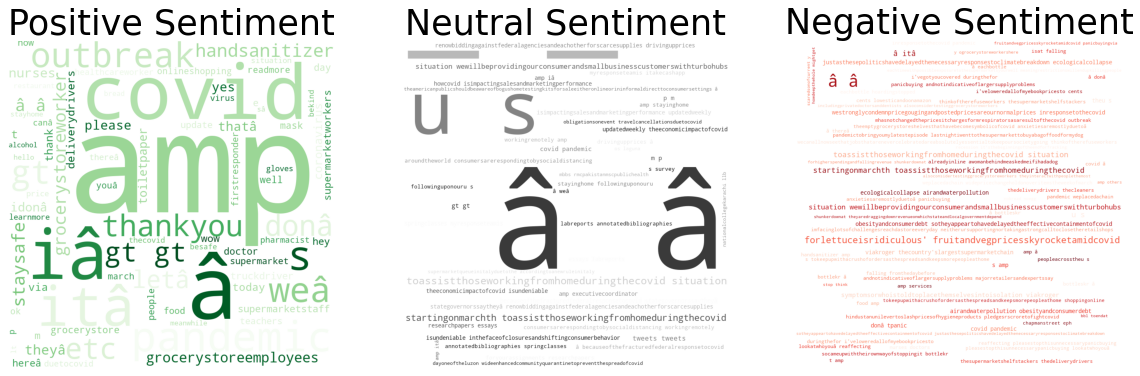

In [186]:
fig, (x1,x2,x3) = plt.subplots(1,3, figsize = [20,15])
df_pos = df[df['Sentiment'] == 'Positive'][:10000]
df_neu = df[df['Sentiment'] == 'Neutral'][:10000]
df_neg = df[df['Sentiment'] == 'Negative'][:10000]

comment_words1 = ''
stopwords = set(STOPWORDS)
for value in df_pos.text:
    value = str(value)
    tokens = value.split() # splitting each text
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words1 += ''.join(tokens) + ''

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words1) 

x1.imshow(wordcloud1)
x1.axis('off')
x1.set_title('Positive Sentiment',fontsize=35);

comment_words2 = ''
for value in df_neu.text:
    value = str(value)
    tokens = value.split()
        # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
        comment_words2 += ''.join(tokens) + ''

wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words2) 

x2.imshow(wordcloud2)
x2.axis('off')
x2.set_title('Neutral Sentiment',fontsize=35);

comment_words3 = ''
for value in df_neg.text:
    value = str(value)
    tokens = value.split()
        # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
        comment_words3 += ''.join(tokens) + ''
        
wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words3) 

x3.imshow(wordcloud3)
x3.axis('off')
x3.set_title('Negative Sentiment',fontsize=35);